In [0]:
%matplotlib inline
from fastai.basics import *
from torchvision import *

## MNIST SGD

In [4]:
d = datasets.mnist.MNIST('./data/', download=True)
dd = datasets.mnist.MNIST('./data/', train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 26043823.08it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 432879.96it/s]
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 7335857.11it/s]                           
8192it [00:00, 183429.01it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [5]:
xt = d.data.float()
yt = d.targets
xt.shape, yt.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [6]:
xv = dd.data.float()
yv = dd.targets
xv.shape, yv.shape

(torch.Size([10000, 28, 28]), torch.Size([10000]))

In [7]:
xt = xt.reshape(60000,-1)
xv = xv.reshape(10000, -1)
xt.shape, xv.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

torch.Size([60000, 784])

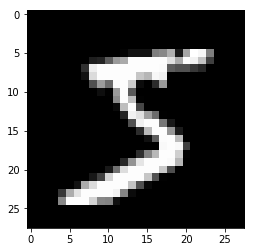

In [8]:
plt.imshow(xt[0].reshape((28,28)), cmap="gray")
xt.shape

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [0]:
bs=64
train_ds = TensorDataset(xt, yt)
valid_ds = TensorDataset(xv, yv)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [10]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

## Logistic Regression 

In [0]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): return self.lin(xb)

In [0]:
model = Mnist_Logistic().cuda()

In [13]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [14]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [15]:
model(x).shape

torch.Size([64, 10])

In [16]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [0]:
lr=1e-5

In [0]:
loss_func = nn.CrossEntropyLoss()  #by default returns the mean loss of the batch

In [0]:
def update(x,y,lr):
    y_hat = model(x)
    loss = loss_func(y_hat, y) 
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [0]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
#     w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

### Simple SGD without weight decay

In [0]:
model = Mnist_Logistic().cuda()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]

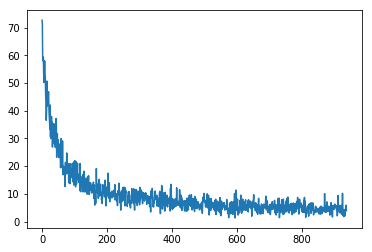

In [37]:
plt.plot(losses);

### SGD with weight decay

In [0]:
model = Mnist_Logistic().cuda()

In [0]:
def update(x,y,lr):
    wd = 1e-2
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

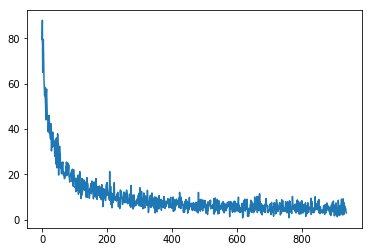

In [62]:
losses = [update(x,y,lr) for x,y in data.train_dl]
plt.plot(losses);

## Fully connected neural network

In [0]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [0]:
model = Mnist_NN().cuda()

In [0]:
losses = [update(x,y,1e-5) for x,y in data.train_dl]

5.266008033823687

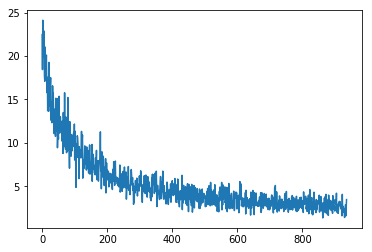

In [59]:
plt.plot(losses); np.array(losses).mean()

In [0]:
model = Mnist_NN().cuda()

### Using optimizer

In [0]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [0]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

1.8613876791048711

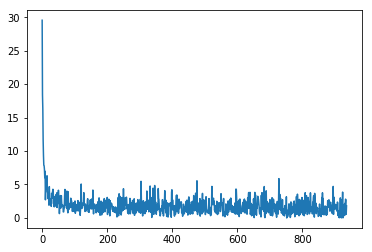

In [66]:
plt.plot(losses); np.array(losses).mean()

In [0]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


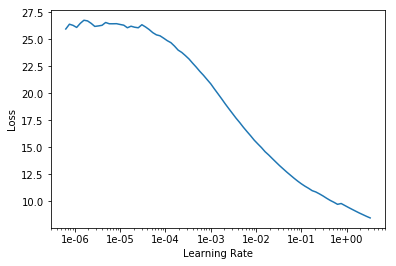

In [68]:
learn.lr_find()
learn.recorder.plot()

In [69]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.136294,1.220582,0.676900,00:05
1,0.867729,0.732192,0.816400,00:06
2,0.464820,0.479727,0.889100,00:06


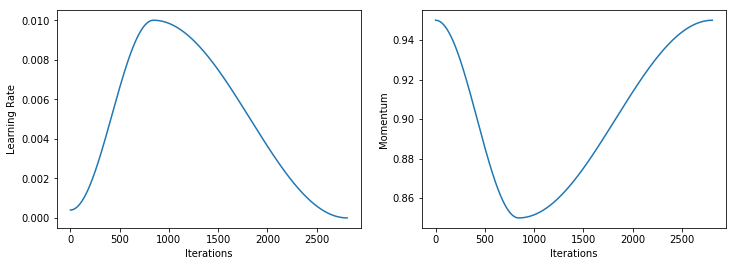

In [70]:
learn.recorder.plot_lr(show_moms=True)

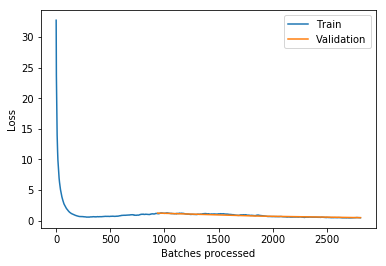

In [71]:
learn.recorder.plot_losses()

In [73]:
learn.fit_one_cycle(3, 1e-2, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,0.515968,0.563367,0.861100,00:06
1,1.029946,1.114354,0.638600,00:06
2,0.684147,0.681001,0.838100,00:06


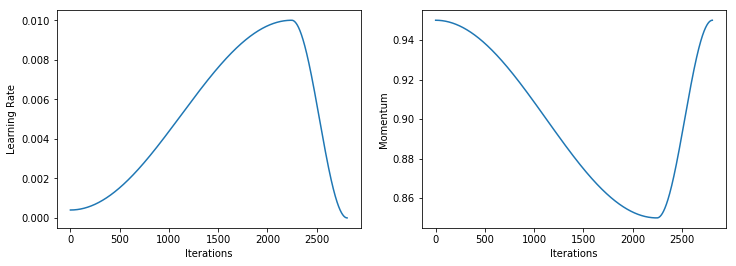

In [74]:
learn.recorder.plot_lr(show_moms=True)

In [76]:
learn.fit_one_cycle(3, 1e-2, pct_start=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.072694,1.072252,0.719300,00:06
1,0.781671,0.713860,0.774100,00:06
2,0.552777,0.576736,0.823200,00:06


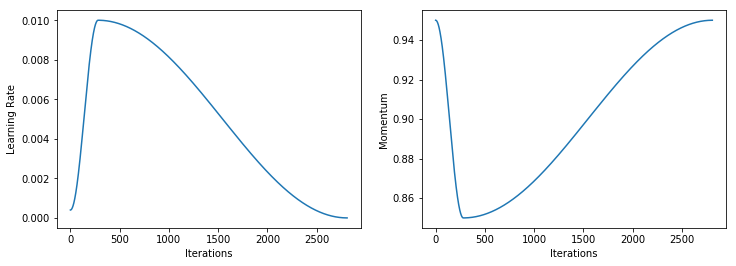

In [77]:
learn.recorder.plot_lr(show_moms=True)

In [85]:
learn.fit_one_cycle(3, 1e-2, div_factor=10, final_div=True)

epoch,train_loss,valid_loss,accuracy,time
0,1.031696,1.128121,0.677000,00:06
1,1.246193,1.149286,0.659200,00:06
2,1.155446,1.125549,0.664700,00:06


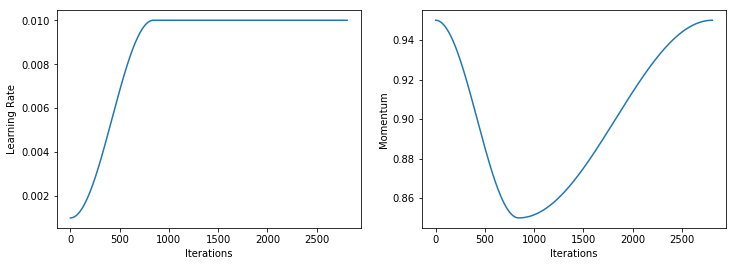

In [86]:
learn.recorder.plot_lr(show_moms=True)